In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import os
import imageio
import scipy
from scipy import ndimage
import cv2
import tensorflow as tf
from tensorflow.python.framework import ops


In [ ]:
# Data load


DIR = '/Users/willcheney/Code/Protein CGR/p53 dataset/'

cat = ['Functional', 'Non-Functional'] # Folder index will be used for labeling

X_data = np.empty((0, 195, 291, 3))

Y = np.array([])

for i in cat:
    counter = 0
    path = os.path.join(DIR, i)

   

    for img in os.listdir( path):
        if counter == 1500:
            break
        image = np.array( imageio.imread( os.path.join(path, img)))


        image = cv2.resize(image, (0,0), fx = 0.2, fy = 0.2)
        image = image/255.0
        image = np.delete(image, 3, axis = 2 )

        image = image.reshape((1,195,291,3))

        X_data = np.append(X_data, image[:,:,:,:], axis = 0)

        

       



           

        Y = np.append(Y, cat.index(i))
        counter += 1
        
        


(2390, 195, 291, 3)


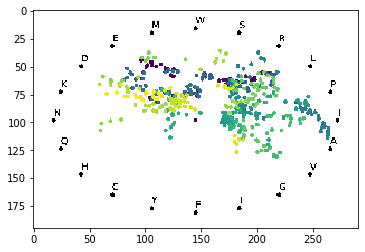

In [5]:
print(X_data.shape)
plt.imshow(X_data[0,:,:,:])
plt.show()

In [6]:
def shuffle(X, y):
    assert X.shape[0] == y.shape[0], 'X data dimension 0, training examples, should equal labels dimension 0 '
    
    x_shuffled = np.empty(X.shape) 
    y_shuffled = np.empty(y.shape)
    
    
    indices = np.arange(X.shape[0])
    rng = np.random.default_rng()
    rng.shuffle(indices)
    
    x_shuffled[:,:,:,:] = X[indices,:,:,:]
    y_shuffled[:] = y[indices]
    
    
    y_shuffled  = y_shuffled.reshape(len(y_shuffled), 1)
    
    return x_shuffled, y_shuffled

def split_data(X, y, dev_percent, test_percent):
    
    assert X.shape[0] == y.shape[0], 'X data dimension 0, training examples, should equal labels dimension 0 '
    
    train_dev_split_index = math.floor(X.shape[0] * (1 - (dev_percent + test_percent)))
    X_train, X_dev = X[0:train_dev_split_index,:,:,:], X[train_dev_split_index:,:,:,:]
    y_train, y_dev = y[0:train_dev_split_index,:], y[train_dev_split_index:,:]
    
    if test_percent == 0:
        return X_train, X_dev, y_train, y_dev
    
    else:
        dev_test_split_index =  math.floor(X_dev.shape[0] * (1 - test_percent/(dev_percent + test_percent)))
        X_dev, X_test = X_dev[0: dev_test_split_index,:,:,: ], X_dev[dev_test_split_index:,:,:,:]
        y_dev, y_test = y_dev[0: dev_test_split_index,: ], y_dev[dev_test_split_index:,:]


        return X_train, X_dev, X_test, y_train, y_dev, y_test
    

In [7]:
np.save('p53_conv_data', X_data)

In [8]:
X_shuffled, Y_shuffled = shuffle(X_data, Y)

In [9]:
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = split_data(X_shuffled, Y_shuffled, .1, .1)

In [10]:
leNet = tf.keras.models.Sequential(name = 'LeNet_5')
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)


leNet.add(tf.keras.layers.Input(shape = X_train.shape[1:], name = 'input_layer'))
leNet.add(tf.keras.layers.Conv2D(6, (5,5), activation = 'relu', strides = 1, name = 'Conv_a1'))

leNet.add(tf.keras.layers.MaxPool2D((2,2), 2, name = 'Max_Pool_a1'))

leNet.add(tf.keras.layers.Conv2D(16, (5,5), activation = 'relu', strides = 1, name = "Conv_b1"))
leNet.add(tf.keras.layers.MaxPool2D((2,2), 2, name = 'Max_Pool_b1'))

leNet.add(tf.keras.layers.Flatten())
leNet.add(tf.keras.layers.Dense(120, activation = 'relu', name = 'Dense_1'))

leNet.add(tf.keras.layers.Dense(84, activation = 'relu', name = 'Dense_2'))

leNet.add(tf.keras.layers.Dense(4, name = 'Classification'))


In [11]:
leNet.compile(loss = loss, optimizer= optimizer, metrics = ['accuracy'])

In [16]:
leNet.summary()

Model: "LeNet_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_a1 (Conv2D)             (None, 191, 287, 6)       456       
_________________________________________________________________
Max_Pool_a1 (MaxPooling2D)   (None, 95, 143, 6)        0         
_________________________________________________________________
Conv_b1 (Conv2D)             (None, 91, 139, 16)       2416      
_________________________________________________________________
Max_Pool_b1 (MaxPooling2D)   (None, 45, 69, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 49680)             0         
_________________________________________________________________
Dense_1 (Dense)              (None, 120)               5961720   
_________________________________________________________________
Dense_2 (Dense)              (None, 84)                1016

In [30]:
leNet.fit(X_train, Y_train, validation_data = (X_dev, Y_dev), epochs = 5, shuffle = True )


Epoch 1/5
8/8 [==============================] - 7s 817ms/step - loss: 0.1418 - accuracy: 0.9414 - val_loss: 0.0837 - val_accuracy: 0.9707
Epoch 2/5
8/8 [==============================] - 6s 762ms/step - loss: 0.0966 - accuracy: 0.9749 - val_loss: 0.0952 - val_accuracy: 0.9540
Epoch 3/5
8/8 [==============================] - 6s 745ms/step - loss: 0.0851 - accuracy: 0.9791 - val_loss: 0.0697 - val_accuracy: 0.9874
Epoch 4/5
8/8 [==============================] - 6s 756ms/step - loss: 0.0669 - accuracy: 0.9791 - val_loss: 0.0606 - val_accuracy: 0.9749
Epoch 5/5
8/8 [==============================] - 6s 738ms/step - loss: 0.0588 - accuracy: 0.9791 - val_loss: 0.0573 - val_accuracy: 0.9874


In [25]:
leNet.save_weights('./p53/leNet5_p53') 

In [32]:
leNet.evaluate(X_test, Y_test)

8/8 [==============================] - 3s 313ms/step - loss: 0.6306 - accuracy: 0.8117


[0.6306078433990479, 0.8117154836654663]